## perguntas a serem respondidas:

- __Quais países recebem maior quantidade de voos de lugares diferentes? (resposta esperada: EUA, Europa)__
- __Quais países voam para maior quantidade de lugares diferentes? (resposta esperada: mesmo que os anteriores)__
- __A rede inicial é uma rede aleatória? (resposta esperada: não)__
- __A rede inicial é livre de escala? Qual o parâmetro? (resposta esperada: sim)__
- A rede inicial é uma rede neutra?
- __A rede inicial possui quantas componentes conexas? Esse número se mantém ao longo do tempo?__
- A rede inicial pode ser separada em grupos/comunidades?
- Qual é a relação entre esses grupos com o passar do tempo?
- __Para cada país, a série temporal de número de países que ele pode viajar possui correlação com o número de casos? (resposta esperada: quando um país possui mais casos, ele passe a poder viajar para menos países)__
- __Quando um país vai remover uma rota de viagem, ele faz de forma aleatória? (resposta esperada: não, ele faz com maior probabilidade para países com maior casos/crescimento de casos)__
- __É possível identificar o impacto das variantes da África do sul e da Inglaterra na rede?__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.express as px
import powerlaw
import json
import scipy.stats as stats
import datetime
plt.style.use('ggplot')

In [2]:
with open('data/countries.json', 'r') as f:
    countries = json.load(f)
countries_coordinates = pd.read_csv('data/countries_coordinates.csv', sep = ';')
    
with open('data/continents.json', 'r') as f:
    continents = json.load(f)
continents = dict([(x['country'], x['continent']) for x in continents])
    
with open('data/initial_network.np', 'rb') as f:
    initial_network = np.load(f)
    
start_date = "2020-01-30"
    
G_initial = nx.from_numpy_matrix(np.transpose(initial_network), create_using = nx.DiGraph)
G_initial.name = 'initial network'

with open('data/temporal_network.np', 'rb') as f:
    temporal_network = np.load(f)

# Network Analysis

## 1. Initial edges distribution 

We start looking at the initial network, the network of travels between countries before the coronavirus pandemic. In this network, with data from years before 2015, each country is represented as a node and a link from node $i$ to node $j$ indicates that it is possible to travel by plane from the country $i$ to country $j$.

Daily people travel from many different countries, but are their decision of destination random? Most people travel for tourism, to know the culture of another country, visit beatiful places, thus, the reputation of the country will probabily influence this decision. Besides that, the number of travel routes for a country have also relation with it's economy and the geography of the country.  We now look at what countries make and recieve the most travels. 

PS.: these plots are heavy.

In [3]:
in_degrees = initial_network.sum(axis = 1)
out_degrees = initial_network.sum(axis = 0)
countries_count = {'country': countries, 'in_degree': in_degrees, 'out_degree':out_degrees,
                  'latitude': [], 'longitude': []}
for i, country in enumerate(countries):
    row = countries_coordinates[countries_coordinates.name == country]
    countries_count['latitude'].append(row.latitude.iloc[0])
    countries_count['longitude'].append(row.longitude.iloc[0])


countries_count = pd.DataFrame(countries_count)

In [4]:
px.set_mapbox_access_token(open("data/mapbox_token").read())
df = countries_count
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",     color="in_degree", size="in_degree",
                  size_max=15, zoom=1, title = "Countries In-Degree")
fig.show()

In [5]:
px.set_mapbox_access_token(open("data/mapbox_token").read())
df = countries_count
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",     color="out_degree", size="out_degree",
                  size_max=15, zoom=1, title = "Countries Out-Degree")
fig.show()

We can identify that the countries from the northen hemisphere are the ones that recieve and make the most travels.

## 2. Mean degree evolution

Looking to evolution of the network overtime, we first need to check if the restrictions really caused an impact in the network, the mean degree is a number that can be computed at each time-stamp and is easy to check for the change in the network.

Important dates:
Date: 2020-03-17 | 47 days since first restriction.
Date: 2020-07-01 | 153 days since first restriction.
Date: 2020-08-08 | 191 days since first restriction.
Date: 2021-02-02 | 369 days since first restriction.


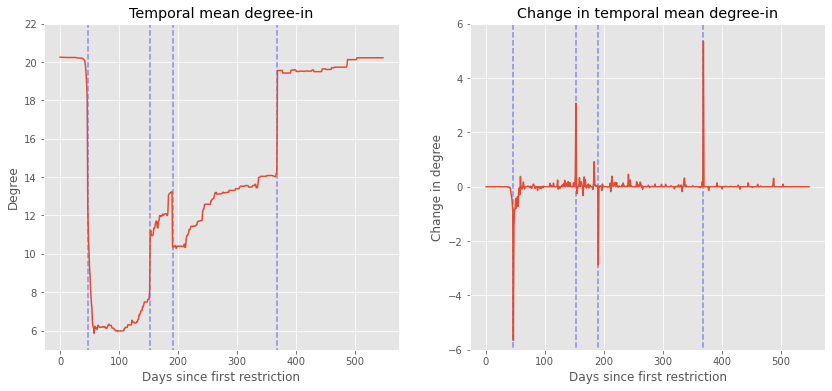

In [6]:
countries_temporal_degree_in_mean = temporal_network.sum(axis = 2).mean(axis = 1)
days_with_big_change = np.where(np.abs(np.diff(countries_temporal_degree_in_mean)) > 2)[0] + 1

n_days = temporal_network.shape[0]
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))

print("Important dates:")
for i in range(len(days_with_big_change)):
    print("Date: " + (pd.to_datetime(start_date) + pd.Timedelta(days = days_with_big_change[i])).strftime("%Y-%m-%d") + " | " +
          str(days_with_big_change[i]) + " days since first restriction.")
    
    
    
ax[0].plot(list(range(n_days)), countries_temporal_degree_in_mean)
ax[0].set_title("Temporal mean degree-in")
ax[0].set_xlabel("Days since first restriction")
ax[0].set_ylabel("Degree")
ax[0].vlines(x = days_with_big_change, ymin = -1, ymax = 25, color = 'blue', linestyles = 'dashed',  alpha = 0.4)
ax[0].set_ylim((5, 22))


ax[1].plot(list(range(1, n_days)), np.diff(countries_temporal_degree_in_mean))
ax[1].set_title("Change in temporal mean degree-in")
ax[1].set_xlabel("Days since first restriction")
ax[1].set_ylabel("Change in degree")
ax[1].vlines(x = days_with_big_change, ymin = -10, ymax = 10, color = 'blue', linestyles = 'dashed', alpha = 0.4)
ax[1].set_ylim((-6, 6))

plt.show()

We can identify a big change in the mean degree of the network, going from $20$ to $6$ in the lowest period, we can identify four big changes in the network, a initial big drop, a big return, a new drop and a return to the original level. We can also identify that the network returned to the original mean degree.

## 3. Random or Scale Free

A random network is a network where when a new node appears, it will link to random nodes to create new edges, i.e., there is no preference for the creation of new edges. Although, a process like this is not common on real world networks, as it is more common to edges exists based on preferences of the nodes. We can verify numerically if our network fits a random model.

For each pair of nodes in a total of $n(n-1)$ (the order matters), there is a probability $p$ of a directed link from one to the other node, so the expected value of links is $\mathbb{E}[L] = pn(n-1)$, with that, $p = \dfrac{\mathbb{E}[L]}{n(n-1)}$, we can replace the expected value of $L$ with the observed value and have an estimative for $p$.

In [7]:
p = len(G_initial.edges)/ ((len(G_initial.nodes) - 1)*len(G_initial.nodes))
print(f"The estimated initial probability is: {np.round(p, 3)}")
p_series = temporal_network.sum(axis = (1, 2)) / ((len(G_initial.nodes) - 1)*len(G_initial.nodes))


The estimated initial probability is: 0.09


With this value, we can simulate a random network with $n$ nodes and compare the distribution of degrees.

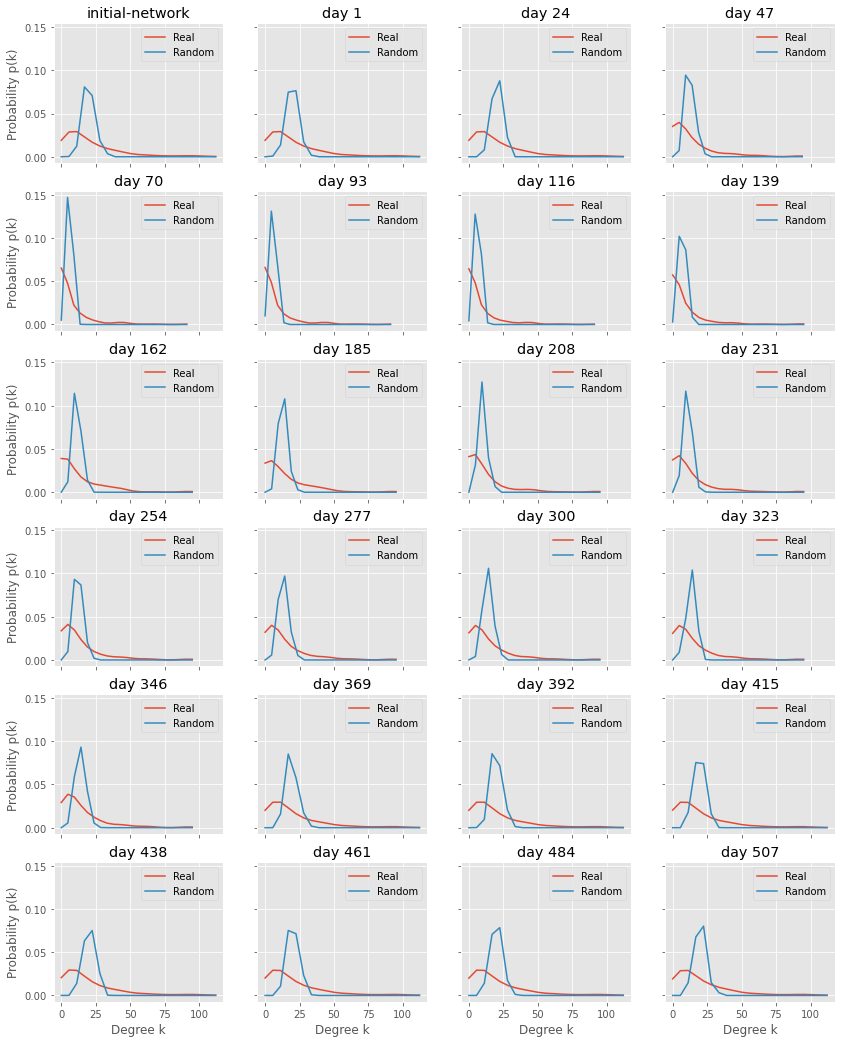

In [8]:
def erdos_renyi(n, p):
    adj = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                r = np.random.random()
                if r < p:
                    adj[i, j] = 1
    return adj

fig, ax = plt.subplots(nrows = 6, ncols = 4, figsize = (14, 18),  sharex=True, sharey=True)
ax = ax.flatten()

random_network = erdos_renyi(len(G_initial.nodes), p)

count, x = np.histogram(initial_network.sum(axis = 1), bins = 20)
density_real = stats.gaussian_kde(initial_network.sum(axis = 1))
density_random = stats.gaussian_kde(random_network.sum(axis = 1))

ax[0].plot(x, density_real(x), label = "Real")
ax[0].plot(x, density_random(x), label = "Random")
ax[0].set_title("initial-network")
ax[0].legend()

for i in range(23):
    day = 1 + (temporal_network.shape[0]//23) * i
    p = p_series[day]
    random_network = erdos_renyi(len(G_initial.nodes), p)
    count, x = np.histogram(temporal_network[day, :, :].sum(axis = 1), bins = 20)
    density_real = stats.gaussian_kde(temporal_network[day, :, :].sum(axis = 1))
    density_random = stats.gaussian_kde(random_network.sum(axis = 1))
    ax[1 + i].plot(x, density_real(x), label = "Real")
    ax[1 + i].plot(x, density_random(x), label = "Random")
    ax[1 + i].set_title("day " + str(day))
    ax[1 + i].legend()

for i in range(1,5):
    ax[-i].xaxis.set_label_text('Degree k')
    
for i in range(0, 24, 4):
    ax[-i].yaxis.set_label_text('Probability p(k)')

plt.show()


As we can see, the distribution of in-degree of the real network follows a power law distribution, meaning that many countries have little links and little countries have many links, but in the random network, it follows a binomial distribution, with most countries having the number of in-degree equals to the mean of the in-degree. The distribution change over time, but it nevers get close to a random network. Now we can verify if our network follows a power law and identify the parameter of the model.

In [9]:
fit_in_degree = powerlaw.Fit(initial_network.sum(axis = 1))
fit_out_degree = powerlaw.Fit(initial_network.sum(axis = 0))

kmax_in_degree = fit_in_degree.xmin*(initial_network.shape[0]**(1/(fit_in_degree.alpha-1)))
kmax_out_degree = fit_out_degree.xmin*(initial_network.shape[0]**(1/(fit_out_degree.alpha-1)))

print("In-degree")
print(f"Gamma: p(k_in) ~= k^{np.round(fit_in_degree.alpha, 3)}")
print(f"Estimated x Observed number of the edges of the biggest node: {kmax_in_degree:.3f}/{initial_network.sum(axis = 1).max():.3f}")

print()
print("Out-degre")
print(f"Gamma: p(k_out) ~= k^{fit_out_degree.alpha:.3f}")
print(f"Estimated x Observed number of the edges of the biggest node: {kmax_out_degree:.3f}/{initial_network.sum(axis = 0).max():.3f}")



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree
Gamma: p(k_in) ~= k^2.636
Estimated x Observed number of the edges of the biggest node: 520.935/112.000

Out-degre
Gamma: p(k_out) ~= k^2.634
Estimated x Observed number of the edges of the biggest node: 522.681/115.000


Values less than or equal to 0 in data. Throwing out 0 or negative values


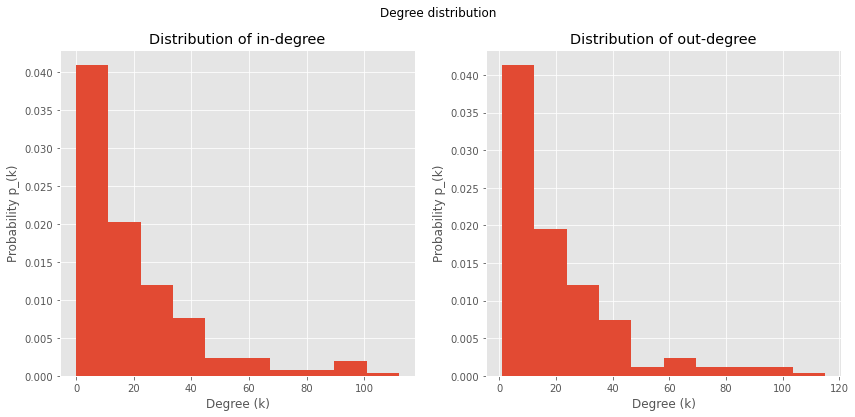

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].hist(initial_network.sum(axis = 1), density = True)
ax[0].set_title("Distribution of in-degree")
ax[1].hist(initial_network.sum(axis = 0), density = True)
ax[1].set_title("Distribution of out-degree")

for i in range(2):
    ax[i].set_xlabel("Degree (k)")
    ax[i].set_ylabel("Probability p_(k)")

plt.suptitle("Degree distribution")
plt.show()


##  Assortativity

Another interesting properties of the network is to look at the covariance of degrees, for a node with degree $k$ we want to know if it is more likely to connected with a node of high degree or with a node of low degree. In our situation, this indicates if small airports travels to other small airports or if they are linked to the bigger ones.

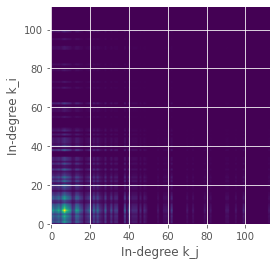

In [11]:
max_in_degree = int(initial_network.sum(axis = 1).max())
degrees_cov = np.zeros((max_in_degree+1, max_in_degree+1))
in_degrees = initial_network.sum(axis = 1)
for i in range(initial_network.shape[0]):
    for j in range(initial_network.shape[0]):
        degree_i = in_degrees[i]
        degree_j = in_degrees[j]
        degrees_cov[int(degree_i), int(degree_j)] += 1
        degrees_cov[int(degree_j), int(degree_i)] += 1

degrees_cov /= initial_network.sum()
plt.imshow(degrees_cov)
plt.ylim((0, max_in_degree))
plt.ylabel("In-degree k_i")
plt.xlabel("In-degree k_j")
plt.show()

## Connected components

A coonected component in a graph is a subset of nodes and edges such that for every two nodes, there is a sequence of edges and nodes such that this two nodes are linked. In our scenario, with we identify more than one connected component, we will find that there is, for example, two different subsets of countries where one country from one subset can't go to any country of the other subset. It is more probable that we found out that there is only one connected component in the initial network, all the countries are linked in some manner, but than we might whant to know, does this connected component remains with the travel restrictions?

A connected component is more easily defined (and calculated) for undirected graphs , and for this interpretation we can ignore the direction of travels to calculate the connected components.

In [12]:
initial_network_undirected = initial_network.copy()
for i in range(initial_network.shape[0]):
    for j in range(initial_network.shape[0]):
        if initial_network[i, j] == 0 and initial_network[j, i] == 0:
            initial_network_undirected[i, j] = 0
        else:
            initial_network_undirected[i, j] = 1

G_undirected = nx.from_numpy_matrix(initial_network_undirected)
print("Number of connected components: " + str(nx.number_connected_components(G_undirected)))

Number of connected components: 1


In [13]:
connected_components_series = []
for t in range(temporal_network.shape[0]):
    temp_undirected = temporal_network[t, :, :].copy()
    for i in range(temp_undirected.shape[0]):
        for j in range(i+1, temp_undirected.shape[0]):
            v = 1
            if temp_undirected[i, j] == 0 and temp_undirected[j, i] == 0:
                v = 0
            temp_undirected[i, j] = v
            temp_undirected[j, i] = v
            
    G_temp_undirected = nx.from_numpy_matrix(temp_undirected)
    connected_components_series.append(nx.number_connected_components(G_temp_undirected))            

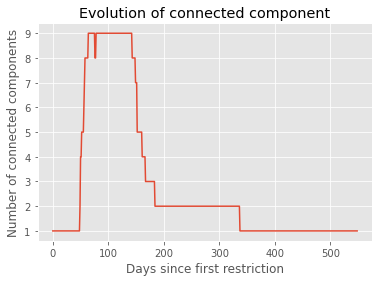

In [14]:
plt.plot(list(range(len(connected_components_series))), connected_components_series)
plt.title("Evolution of connected component")
plt.xlabel("Days since first restriction")
plt.ylabel("Number of connected components")
plt.show()

As we can see, there is a moment of the observed time when the restrictions cause the network to break into many connected components, having a total of 9 connected components into the biggest period.

## Restrictions pattern

To understand the evolution of the network overtime, we might want to know if the restrictions show some pattern, for example, an initial analysis would be if the restrictions is distributed equally between countries, or if countries with small initial number of edges have less restrictions.

# Analysis of network evolution

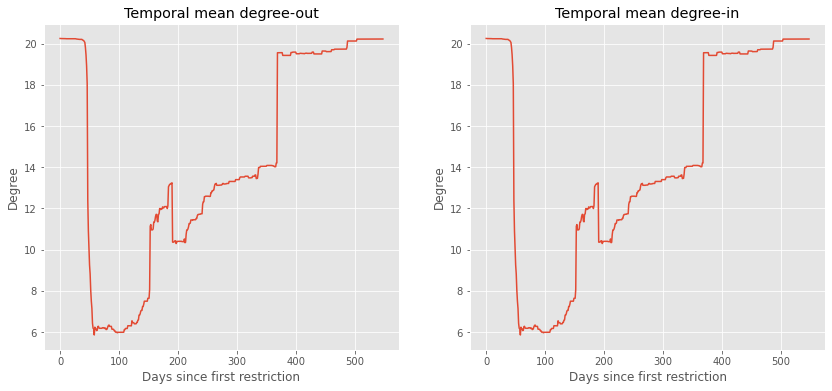

In [8]:
countries_temporal_degree_out_mean = temporal_network.sum(axis = 1).mean(axis = 1)
countries_temporal_degree_in_mean = temporal_network.sum(axis = 2).mean(axis = 1)
n_days = temporal_network.shape[0]
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].plot(list(range(n_days)), countries_temporal_degree_out_mean)
ax[0].set_title("Temporal mean degree-out")
ax[1].plot(list(range(n_days)), countries_temporal_degree_in_mean)
ax[1].set_title("Temporal mean degree-in")

for i in range(2):
    ax[i].set_xlabel("Days since first restriction")
    ax[i].set_ylabel("Degree")
plt.show()

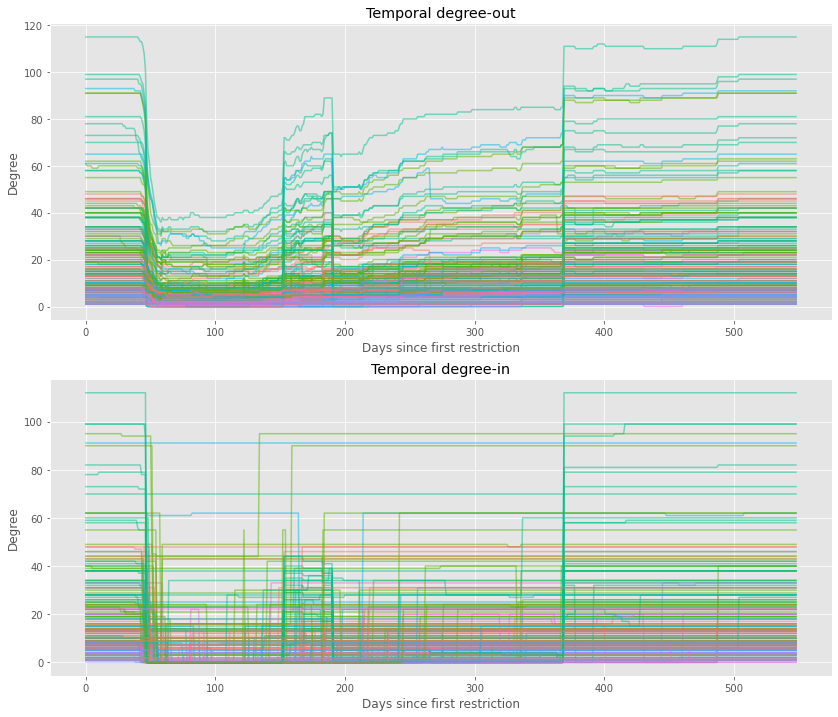

In [9]:
countries_temporal_degree_out = list(zip(countries, temporal_network.sum(axis = 1).transpose()))
countries_temporal_degree_in = list(zip(countries, temporal_network.sum(axis = 2).transpose()))

colors = {'Africa': "#F8766D", "Antartica": "#C59900",
         "Asia": "#5bb300", "Europe": "#00c08d", 
         "North America": "#00b8e5", "Oceania": "#9590ff",
         "South America": "#f763e0"}

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 12))
for i in range(len(countries)):
    country = countries_temporal_degree_out[i][0]
    color = colors[continents[country]]
    ax[0].plot(list(range(n_days)), countries_temporal_degree_out[i][1], c = color, alpha = 0.5)
    country = countries_temporal_degree_in[i][0]
    color = colors[continents[country]]
    ax[1].plot(list(range(n_days)), countries_temporal_degree_in[i][1], c = color, alpha = 0.5)
ax[0].set_title("Temporal degree-out")
ax[1].set_title("Temporal degree-in")



for i in range(2):
    ax[i].set_xlabel("Days since first restriction")
    ax[i].set_ylabel("Degree")
plt.show()

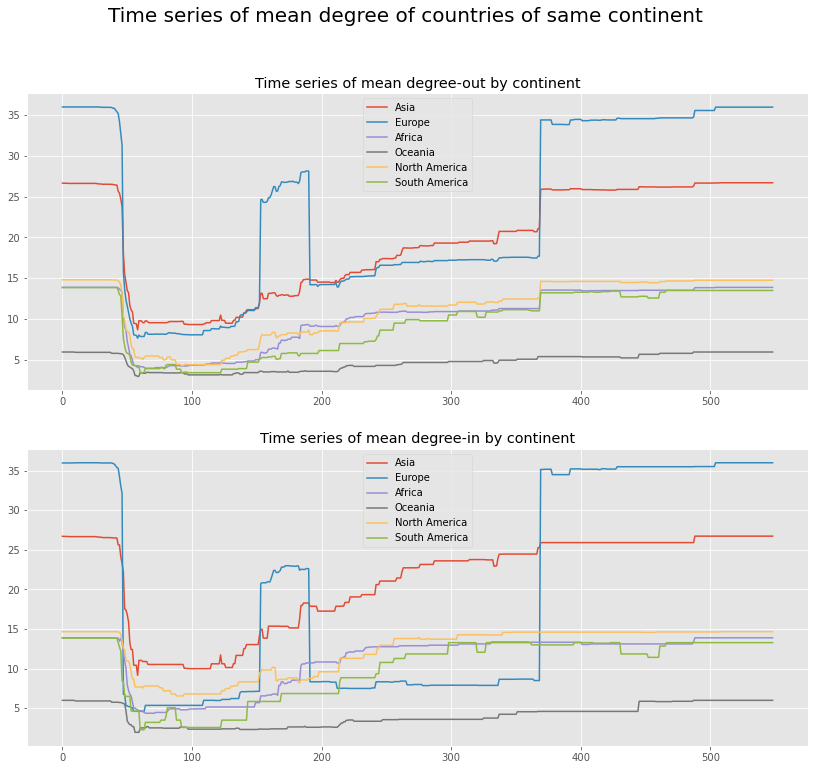

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 12))

countries_map = {countries[i]:i for i in range(0,len(countries))}
continents_temporal_degrees_out = dict([(v, []) for v in continents.values()])
for country in countries:
    country_i = countries_map[country]
    cont = continents[country]
    continents_temporal_degrees_out[cont].append(temporal_network[:, :, country_i].sum(axis = 1))
for cont in continents_temporal_degrees_out.keys():
    if len(continents_temporal_degrees_out[cont]) > 0:
        continents_temporal_degrees_out[cont] = np.mean(continents_temporal_degrees_out[cont], axis = 0)
        ax[0].plot(list(range(n_days)), continents_temporal_degrees_out[cont], label = cont)
ax[0].legend()


ax[0].set_title("Time series of mean degree-out by continent")

continents_temporal_degrees_in = dict([(v, []) for v in continents.values()])
for country in countries:
    country_i = countries_map[country]
    cont = continents[country]
    continents_temporal_degrees_in[cont].append(temporal_network[:, country_i, :].sum(axis = 1))
for cont in continents_temporal_degrees_in.keys():
    if len(continents_temporal_degrees_in[cont]) > 0:
        continents_temporal_degrees_in[cont] = np.mean(continents_temporal_degrees_in[cont], axis = 0)
        ax[1].plot(list(range(n_days)), continents_temporal_degrees_in[cont], label = cont)
ax[1].legend()
ax[1].set_title("Time series of mean degree-in by continent")

plt.suptitle("Time series of mean degree of countries of same continent", size = 20)
plt.show()

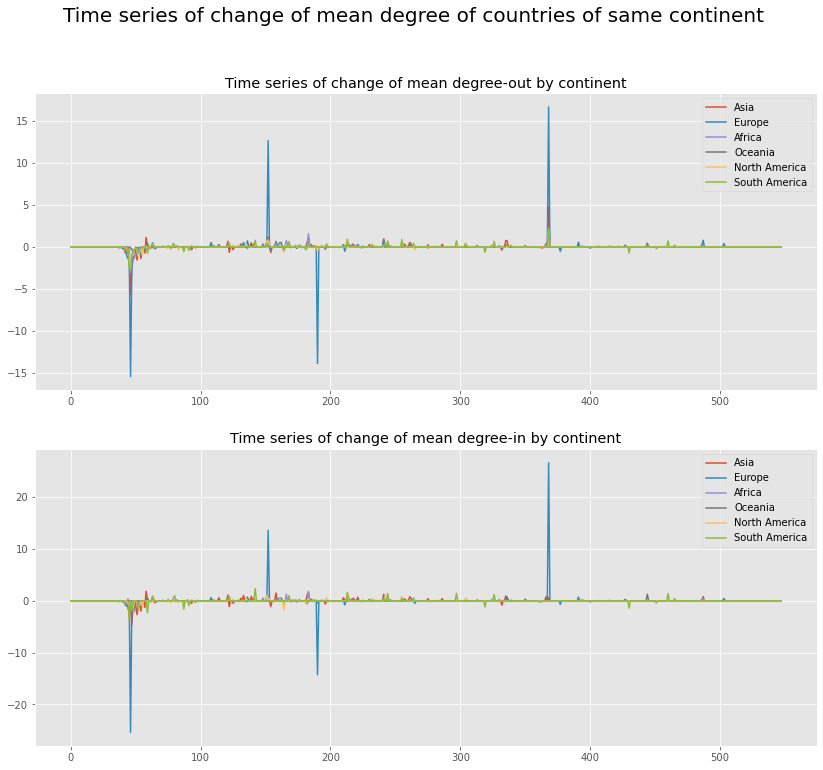

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (14, 12))

for cont in continents_temporal_degrees_out.keys():
    if len(continents_temporal_degrees_out[cont]) > 0:
        ax[0].plot(list(range(n_days - 1)), np.diff(continents_temporal_degrees_out[cont]), label = cont)
ax[0].legend()
ax[0].set_title("Time series of change of mean degree-out by continent")

for cont in continents_temporal_degrees_in.keys():
    if len(continents_temporal_degrees_in[cont]) > 0:
        ax[1].plot(list(range(n_days- 1)), np.diff(continents_temporal_degrees_in[cont]), label = cont)
ax[1].legend()
ax[1].set_title("Time series of change of mean degree-in by continent")

plt.suptitle("Time series of change of mean degree of countries of same continent", size = 20)
plt.show()

## Scale free network

In [19]:
#this cell will probably take time
G = [nx.from_numpy_matrix(temporal_network[i, :, :], create_using = nx.DiGraph) for i in range(n_days)]

In [20]:
max_degree = [temporal_network[i, :, :].sum(axis = 0).max() for i in range(n_days)]

In [21]:
import powerlaw

In [22]:
fit = [powerlaw.Fit(temporal_network[i, :, :].sum(axis = 1), discrete=True) for i in range(n_days)]

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 78%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 85%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 87%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 15%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 60%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 88%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 10%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 16%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 91%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values



Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 26%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 84%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 57%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 77%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 68%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 65%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 13%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 27%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 31%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 18%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 18%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 25%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 39%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 36%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 74%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 96%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 60%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 54%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 30%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 16%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 66%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 66%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 83%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 75%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 50%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
xmin progress: 07%

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [23]:
N = len(countries)
kmax = [f.xmin*(N**(1/(f.alpha-1))) for f in fit]

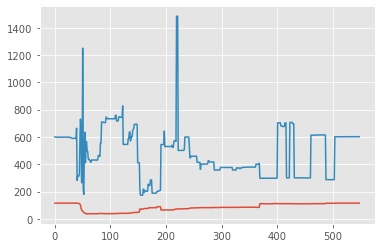

In [24]:
plt.plot(list(range(n_days)), max_degree)
plt.plot(list(range(n_days)), kmax)

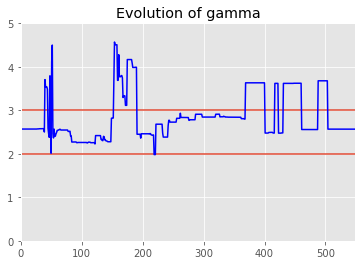

In [25]:
plt.title("Evolution of gamma")
plt.plot(list(range(n_days)), [f.alpha for f in fit], c = "blue")
plt.hlines(2, 0, n_days)
plt.hlines(3, 0, n_days)
plt.ylim((0, 5))
plt.xlim((0, n_days))
plt.show()

In [26]:
components = [nx.number_connected_components(g) for g in G]

NetworkXNotImplemented: not implemented for directed type

# Importing Covid Data

In [12]:
covid_data = pd.read_csv('data/owid-covid-data.csv')
covid_data = covid_data[['iso_code','location','date','total_cases','new_cases']]
covid_data['date'] = pd.to_datetime(covid_data['date'])
initial_date = pd.Timestamp('2020-01-30 00:00:00')
final_date = initial_date + datetime.timedelta(days=549)
covid_data = covid_data[(covid_data['date'] >= initial_date) & (covid_data['date'] < final_date)]
covid_data.head()

iso_code     location       date  total_cases  new_cases
0      AFG  Afghanistan 2020-02-24          1.0        1.0
1      AFG  Afghanistan 2020-02-25          1.0        0.0
2      AFG  Afghanistan 2020-02-26          1.0        0.0
3      AFG  Afghanistan 2020-02-27          1.0        0.0
4      AFG  Afghanistan 2020-02-28          1.0        0.0

In [13]:
len([c for c in countries if c in covid_data['location'].values])

197

In [14]:
countries_stats = {'c':[],'n_days':[],'n_na':[]}
for c in countries:
    rows = covid_data.loc[covid_data['location']==c]
    if rows.shape[0]>0:
        countries_stats['c'].append(c)
        countries_stats['n_days'].append(len(rows['date'].unique()))
        countries_stats['n_na'].append(np.sum(rows['total_cases'].isna().values) + 
                                      np.sum(rows['new_cases'].isna().values))
countries_stats = pd.DataFrame(countries_stats)
countries_stats.head()

c  n_days  n_na
0  Afghanistan     524     0
1      Albania     523    26
2      Algeria     523     0
3       Angola     499     0
4     Anguilla     178   356

In [15]:
def fix_series(ts):
    ts = np.nan_to_num(ts)
    ts[ts<0] = 0
    return ts
countries_available = countries_stats[(countries_stats['n_days'].values == 549) & 
                                      (countries_stats['n_na'].values == 0)]['c'].values
final_covid = {'c':[],'total_cases':[],'new_cases':[]}
for c in countries_available:
    rows = covid_data.loc[covid_data['location']==c]
    rows.sort_values(by=['date'],ascending=True)
    final_covid['c'].append(c)
    final_covid['total_cases'].append(fix_series(rows['total_cases'].values))
    final_covid['new_cases'].append(fix_series(rows['new_cases'].values))
final_covid = pd.DataFrame(final_covid)
final_covid.head()

c                                        total_cases  \
0  Australia  [9.0, 9.0, 12.0, 12.0, 12.0, 13.0, 13.0, 14.0,...   
1   Cambodia  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
2     Canada  [2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 7.0, ...   
3      China  [8131.0, 9790.0, 11878.0, 16615.0, 19701.0, 23...   
4    Finland  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                           new_cases  
0  [3.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, ...  
3  [2054.0, 1659.0, 2088.0, 4737.0, 3086.0, 3989....  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

## Covid data analysis

In [16]:
def minmaxscaler(x):
    if np.min(x)>=0:
        return x/np.max(x)
    else:
        return (x+np.min(x))/(np.max(x)+np.min(x))

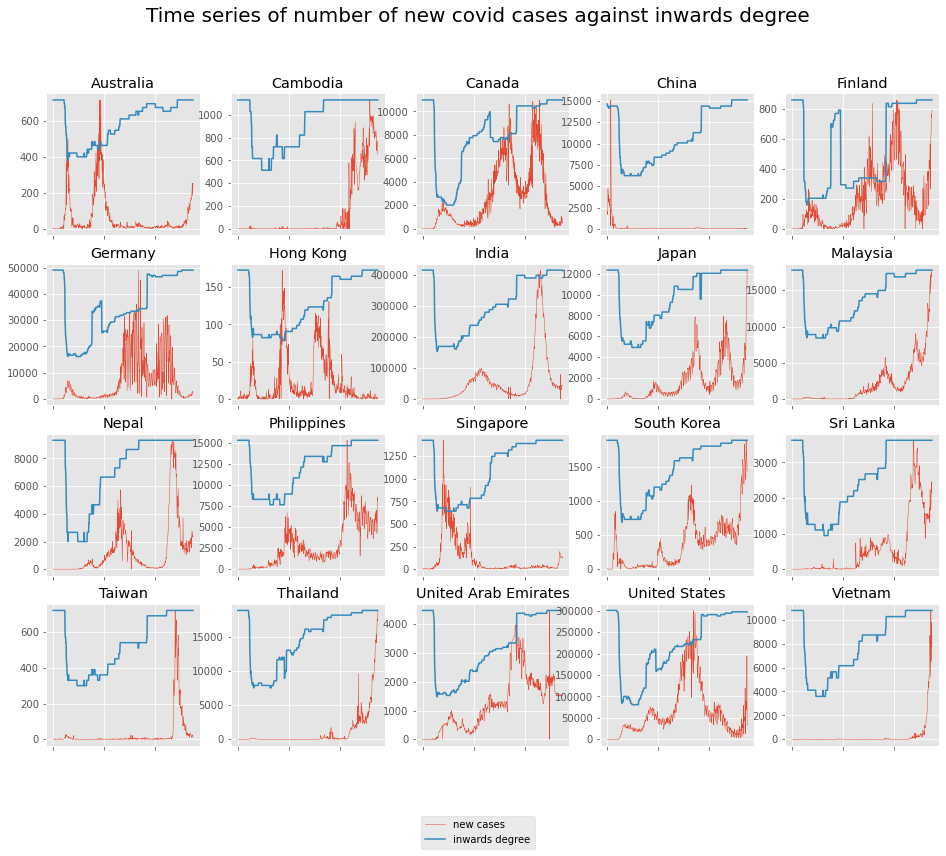

In [17]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (16, 12))
for i in range(20):
    nrow = i//5
    ncol = i%5
    c = final_covid['c'][i]
    covid_cases_i = final_covid['new_cases'][i]
    max_i = np.max(covid_cases_i)
    in_degree_i = temporal_network[:,:,countries_map[c]].sum(axis=1)
    in_degree_i = max_i*minmaxscaler(in_degree_i)
    curax = ax[nrow][ncol]
    curax.plot(list(range(n_days)), covid_cases_i, label = 'new cases', linewidth = 0.5)
    curax.plot(list(range(n_days)), in_degree_i, label = 'inwards degree')
    curax.set_title(c)
    curax.set_xticklabels([])

lines_labels = [ax[0][0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
plt.legend( lines, labels, loc = 'lower center', bbox_to_anchor = (0,0,1,1),
            bbox_transform = plt.gcf().transFigure )
plt.suptitle("Time series of number of new covid cases against inwards degree", size = 20)
plt.show()

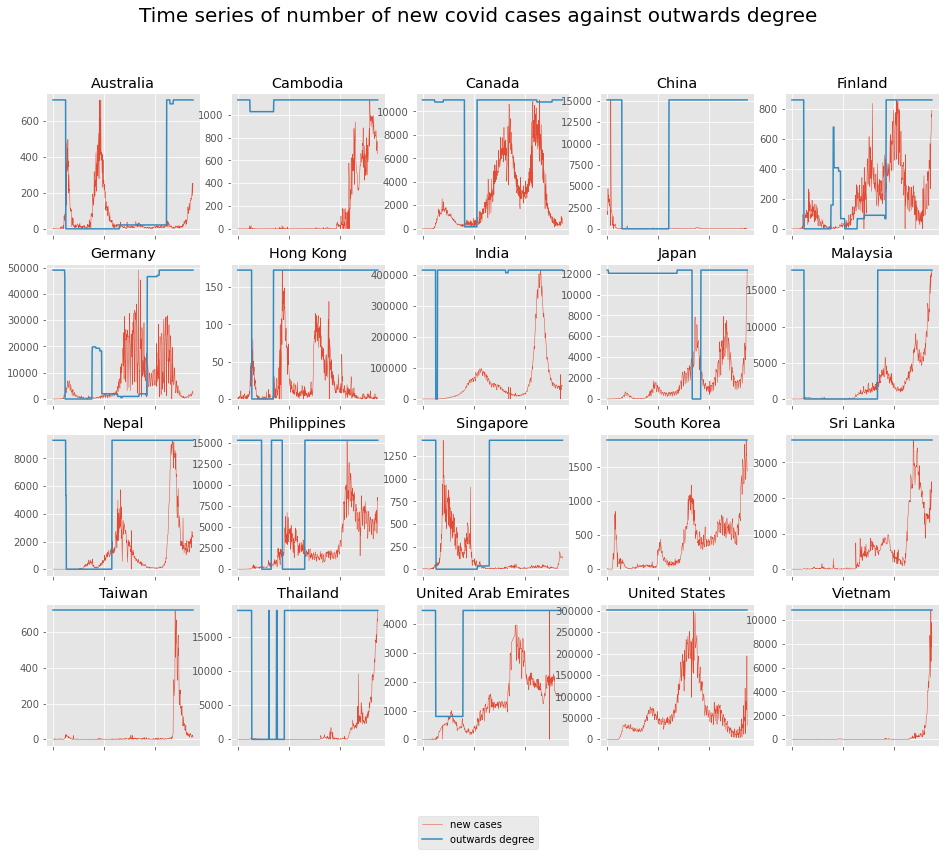

In [18]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (16, 12))
for i in range(20):
    nrow = i//5
    ncol = i%5
    c = final_covid['c'][i]
    covid_cases_i = final_covid['new_cases'][i]
    max_i = np.max(covid_cases_i)
    out_degree_i = temporal_network[:,countries_map[c],:].sum(axis=1)
    out_degree_i = max_i*minmaxscaler(out_degree_i)
    curax = ax[nrow][ncol]
    curax.plot(list(range(n_days)), covid_cases_i, label = 'new cases', linewidth = 0.5)
    curax.plot(list(range(n_days)), out_degree_i, label = 'outwards degree')
    curax.set_title(c)
    curax.set_xticklabels([])

lines_labels = [ax[0][0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
plt.legend( lines, labels, loc = 'lower center', bbox_to_anchor = (0,0,1,1),
            bbox_transform = plt.gcf().transFigure )
plt.suptitle("Time series of number of new covid cases against outwards degree", size = 20)
plt.show()

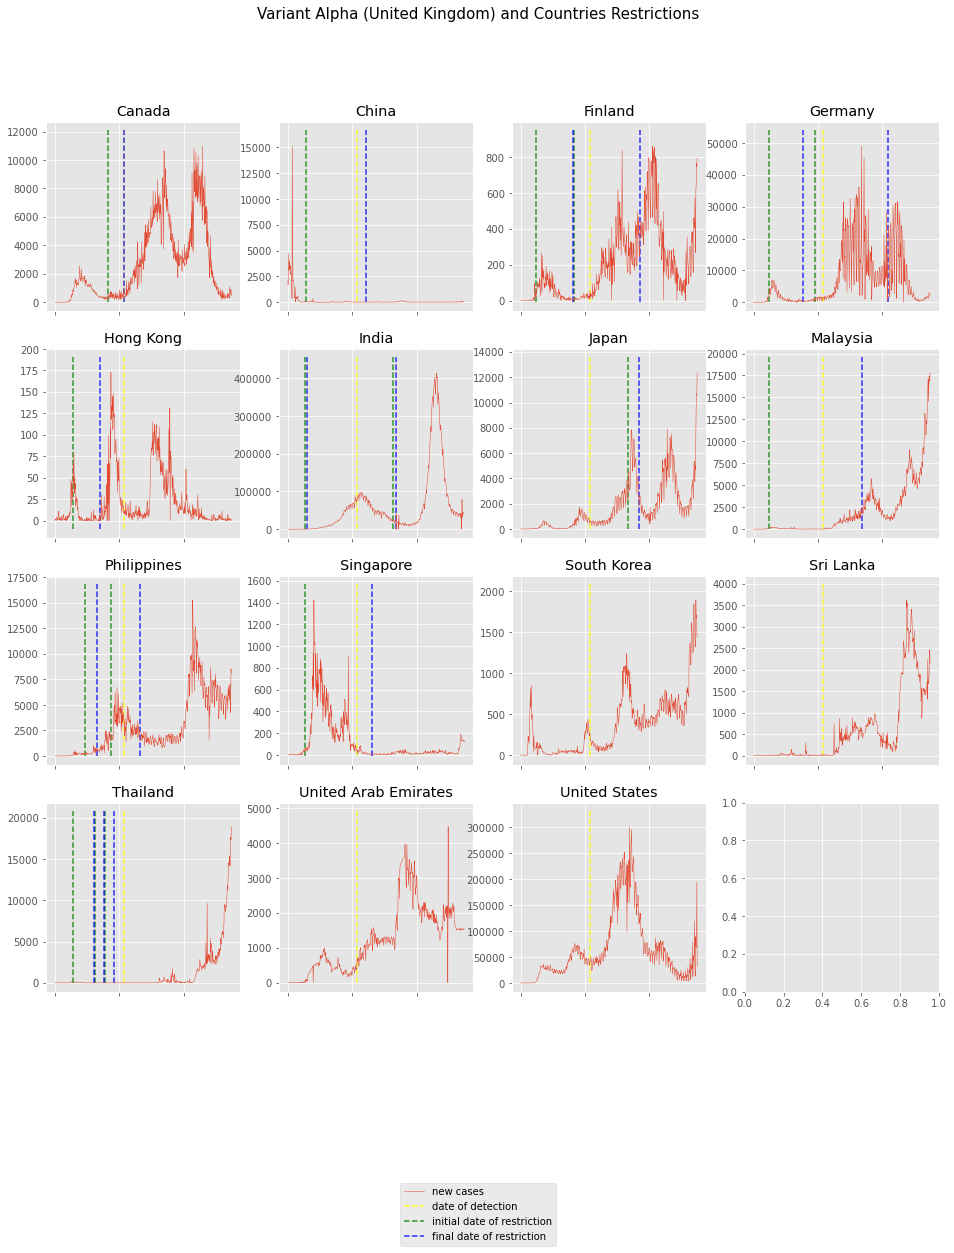

In [95]:
variants = {'name':['Alpha','Beta','Gamma','Delta'],
           'c':['United Kingdom','South Africa','Brazil','India'],
           'date':['2020-09-01 00:00:00','2020-05-01 00:00:00','2020-11-01 00:00:00','2020-10-01 00:00:00']}
variants['date'] = [pd.Timestamp(d) for d in variants['date']]
variants = pd.DataFrame(variants)

countries_available_i = [countries_map[c] for c in countries_available]

def plot_variant(variant):
    name, c, date = variant['name'], variant['c'], variant['date']
    data = temporal_network[:, countries_available_i, countries_map[c]]
    countries_inds = (data.sum(axis=0))>0
    countries_inds = np.arange(countries_inds.shape[0])[countries_inds]
    countries_names = countries_available[countries_inds]
    ncountries = countries_names.shape[0]
    nplots = np.max(ncountries)
    nrow = 1+int((nplots-1)//4)
    ncol = 4
    fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (16, 4*nrow))
    for i in range(nplots):
        curax = ax[i//4][i%4] if nrow > 1 else ax[i%4]
        # covid data
        covid_cases_i = final_covid['new_cases'][countries_inds[i]]
        curax.plot(list(range(n_days)), covid_cases_i, label = 'new cases', linewidth = 0.5)
        # initial variant date
        xline = (date - initial_date).days
        curax.vlines(x = xline, ymin = -10, ymax = 1.1*np.max(covid_cases_i),
                     color = 'yellow', linestyles = 'dashed', alpha = 0.8, label = 'date of detection')
        # temporal changes
        xlines = np.diff(data[:,countries_inds[i]])
        xlines = np.arange(xlines.shape[0])[xlines!=0] + 1
        curax.vlines(x = xlines[[i for i in range(xlines.shape[0]) if i%2==0]], ymin = -10, ymax = 1.1*np.max(covid_cases_i),
                     color = 'green', linestyles = 'dashed', alpha = 0.8, label = 'initial date of restriction')
        curax.vlines(x = xlines[[i for i in range(xlines.shape[0]) if i%2==1]], ymin = -10, ymax = 1.1*np.max(covid_cases_i),
                     color = 'blue', linestyles = 'dashed', alpha = 0.8, label = 'final date of restriction')
        # plot aesthetics
        curax.set_title(countries_names[i])
        curax.set_xticklabels([])

    lines_labels = [curax.get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    plt.legend( lines, labels, loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
                bbox_transform = plt.gcf().transFigure )
    plt.suptitle('Variant '+name+' ('+c+') and Countries Restrictions', size = 15)
    plt.show()
        
    
    
plot_variant(variants.loc[0])